In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import netCDF4 as nc
from scipy import spatial as spat

import sys
sys.path.append('../')
from src import data
from src import visualization as vis

import os

In [2]:
def get_datafiles_for_year(year, months):
    directory = "../../../gom3_hourly"
    file_paths = []
    for m in months:
        fname = directory+"/gom3_{}{}.nc".format(year, str(m).zfill(2))
        if os.path.exists(fname):
            file_paths.append(fname)

    return file_paths

def get_temp_for_year(year, months):
    files = get_datafiles_for_year(year, months)
    temps = np.zeros(shape=(1,))
    depths = np.zeros(shape=(1,))
    
    for f in files:
        d = nc.Dataset(f)

        t = d.variables['temp'][0, 0, :].data
        h = d.variables['h'][:].data
        la = d.variables['y'][:].data
        lo = d.variables['x'][:].data
        
        coords = np.hstack((np.array([lo]).transpose(), np.array([la]).transpose()))
        good = get_spaced_point(coords)
        
        temps = np.concatenate((temps, t[good]))
        depths = np.concatenate((depths, h[good]))

        d.close()

    return temps, depths

def get_temp_for_all_years(years, months):

    temps = np.zeros(shape=(1,))
    depths = np.zeros(shape=(1,))

    for y in years:
        t, h = get_temp_for_year(y, months)
        temps = np.concatenate((temps, t))
        depths = np.concatenate((depths, h))

    return temps, depths

In [3]:
def get_spaced_point(coords):
    N = len(coords)
    good_points = np.array(list(range(N)))
    good_points = good_points.astype(float)
    min_spacing = 10000
    for i in range(N):
        if ~np.isnan(good_points[i]):
            #print(i)
            dist = np.sqrt(np.square(coords[:, 0] - coords[i, 0]) + np.square(coords[:, 1] - coords[i, 1]))
            idx = dist < min_spacing
            #print(dist)
            good_points[idx] = np.nan
            good_points[i] = i
            
    good = good_points[~np.isnan(good_points)]
    good = good.astype(int)
            
    return good

In [5]:
def compute_temp_histograms(settled, complete, bins, r, save=None):
    h_settled_temp, bins = np.histogram(settled, bins=bins, range=r)
    h_settled_temp = h_settled_temp/np.sum(h_settled_temp)

    h_all_temps, bins = np.histogram(complete, bins=bins, range=r)
    h_all_temps = h_all_temps/np.sum(h_all_temps)

    h_std = h_settled_temp/h_all_temps
    
    return h_settled_temp, h_all_temps, h_std, bins

def plot_temp_histograms(settled, complete, bins, r, save=None):
    h_settled_temp, h_all_temps, h_std, bins = compute_temp_histograms(settled, complete, bins, r)

    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4))

    ax1.bar(center, h_settled_temp, align='center', width=width, label="Settled Temperature")
    ax1.bar(center, h_all_temps, align="center", width=width, alpha=0.5, label="Complete Temperature")
    ax1.set_title("Settled Temperature Distribution")
    ax1.set_ylabel("Proportion of Settled Particles")
    ax1.set_xlabel("Temperature (˚C)")
    ax1.set_ylim((0, 0.15))
    ax1.legend()

    ax2.bar(center, h_std, align='center', width=width)
    ax2.hlines(1.00, r[0], r[1], color="k")
    ax2.set_title("JPMF of Temperature")
    ax2.set_xlabel("Temperature (˚C)")

    if save:
        plt.savefig("../figs/settlement-probability/{}".format(save))

    return ax1, ax2, h_settled_temp, h_all_temps, h_std


def compute_depth_histograms(settled, complete, bins, r, save=None):
    h_settled_depth, bins = np.histogram(settled, bins=bins, range=r)
    h_settled_depth = h_settled_depth/np.sum(h_settled_depth)

    h_all_depths, bins = np.histogram(complete, bins=bins, range=r)
    h_all_depths = h_all_depths/np.sum(h_all_depths)

    h_std = h_settled_depth/h_all_depths

    return h_settled_depth, h_all_depths, h_std, bins
 
def plot_depth_histograms(settled, complete, bins, r, save=None):
    h_settled_depth, h_all_depths, h_std, bins = compute_depth_histograms(settled, complete, bins, r)
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4))

    ax1.bar(center, h_settled_depth, align='center', width=width, label="Settled deptherature")
    ax1.bar(center, h_all_depths, align="center", width=width, alpha=0.5, label="Complete deptherature")
    ax1.set_title("Settled Depth Distribution")
    ax1.set_ylabel("Proportion of Settled Particles")
    ax1.set_xlabel("Depth (m)")
    ax1.set_ylim((0, 0.1))
    ax1.legend()

    ax2.bar(center, h_std, align='center', width=width)
    ax2.hlines(1.00, r[0], r[1], color="k")
    ax2.set_title("JPMF of Depth")
    ax2.set_xlabel("Depth (m)")

    if save:
        plt.savefig("../figs/settlement-probability/{}".format(save))

    return ax1, ax2, h_settled_depth, h_all_depths, h_std

In [6]:
months = range(2, 9)
fname = "fiscm_group_001.nc"

In [7]:
base_temps, base_depths = get_temp_for_all_years(range(1984, 1989), months)
warm_temps, warm_depths = get_temp_for_all_years(range(2012, 2017), months)
cold_temps, cold_depths = get_temp_for_all_years(range(1993, 1998), months)

In [125]:
baseline_start, baseline_end, baseline_settled = data.get_data_for_years(
    '../../model_runs/data/atlantic-cod/baseline_data', 
    range(1984, 1989), 
    "settlement.nc"
)

baseline_settled     = baseline_settled.astype(int)
baseline_sett_temps  = baseline_end[baseline_settled, 3]
baseline_sett_depths = baseline_end[baseline_settled, 4]

baseline_unsett_temps  = baseline_end[~baseline_settled, 3]
baseline_unsett_depths = baseline_end[~baseline_settled, 4]

['../../model_runs/data/atlantic-cod/baseline_data/Year1984/01-jan/settlement.nc', '../../model_runs/data/atlantic-cod/baseline_data/Year1984/03-mar/settlement.nc', '../../model_runs/data/atlantic-cod/baseline_data/Year1984/05-may/settlement.nc', '../../model_runs/data/atlantic-cod/baseline_data/Year1984/02-feb/settlement.nc', '../../model_runs/data/atlantic-cod/baseline_data/Year1984/04-apr/settlement.nc']
['../../model_runs/data/atlantic-cod/baseline_data/Year1985/01-jan/settlement.nc', '../../model_runs/data/atlantic-cod/baseline_data/Year1985/03-mar/settlement.nc', '../../model_runs/data/atlantic-cod/baseline_data/Year1985/05-may/settlement.nc', '../../model_runs/data/atlantic-cod/baseline_data/Year1985/02-feb/settlement.nc', '../../model_runs/data/atlantic-cod/baseline_data/Year1985/04-apr/settlement.nc']
['../../model_runs/data/atlantic-cod/baseline_data/Year1986/01-jan/settlement.nc', '../../model_runs/data/atlantic-cod/baseline_data/Year1986/03-mar/settlement.nc', '../../model_

In [126]:
warm_start, warm_end, warm_settled = data.get_data_for_years(
    '../../model_runs/data/atlantic-cod/warm_period', 
    range(2012, 2017), 
    "settlement.nc"
)

warm_settled     = warm_settled.astype(int)
warm_sett_temps  = warm_end[warm_settled, 3]
warm_sett_depths = warm_end[warm_settled, 4]

warm_unsett_temps  = warm_end[~warm_settled, 3]
warm_unsett_depths = warm_end[~warm_settled, 4]

['../../model_runs/data/atlantic-cod/warm_period/Year2012/03-mar/settlement.nc', '../../model_runs/data/atlantic-cod/warm_period/Year2012/05-may/settlement.nc', '../../model_runs/data/atlantic-cod/warm_period/Year2012/02-feb/settlement.nc', '../../model_runs/data/atlantic-cod/warm_period/Year2012/04-apr/settlement.nc']
['../../model_runs/data/atlantic-cod/warm_period/Year2013/03-mar/settlement.nc', '../../model_runs/data/atlantic-cod/warm_period/Year2013/05-may/settlement.nc', '../../model_runs/data/atlantic-cod/warm_period/Year2013/02-feb/settlement.nc', '../../model_runs/data/atlantic-cod/warm_period/Year2013/04-apr/settlement.nc']
['../../model_runs/data/atlantic-cod/warm_period/Year2014/03-mar/settlement.nc', '../../model_runs/data/atlantic-cod/warm_period/Year2014/05-may/settlement.nc', '../../model_runs/data/atlantic-cod/warm_period/Year2014/02-feb/settlement.nc', '../../model_runs/data/atlantic-cod/warm_period/Year2014/04-apr/settlement.nc']
['../../model_runs/data/atlantic-cod/

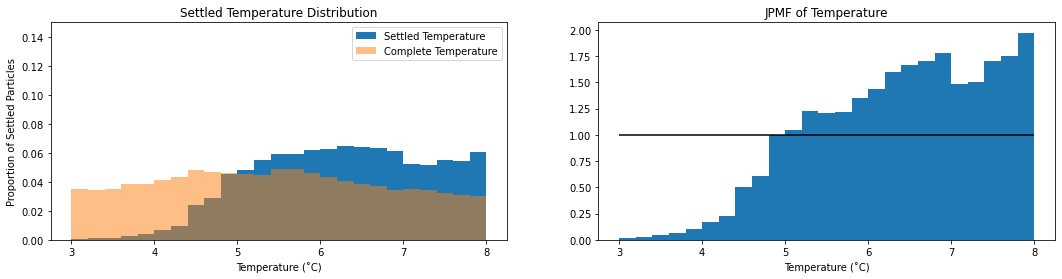

In [10]:
ax1, ax2, h_settled_temp, h_all_temps, h_std_base = plot_temp_histograms(baseline_sett_temps, base_temps, 25, (3,8), save="cod_base_temp.png")

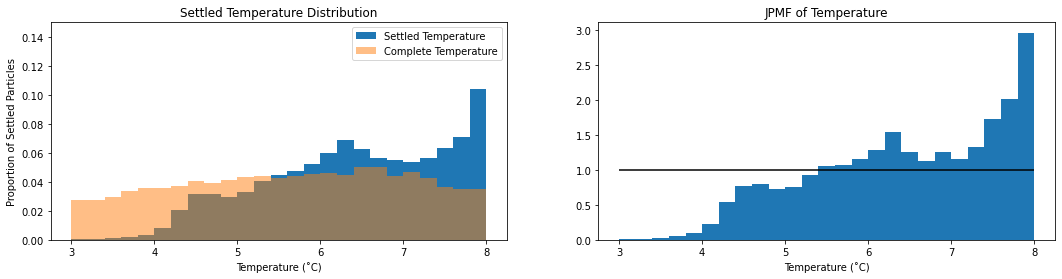

In [11]:
ax1, ax2, h_settled_temp, h_all_temps, h_std_warm = plot_temp_histograms(warm_sett_temps, warm_temps, 25, (3,8), save="cod_warm_temp.png")

In [128]:
h_settled_temp_base, h_all_temps_base, h_std_base, base_bins = compute_temp_histograms(baseline_sett_temps, base_temps, 25, (3,8))
h_settled_temp_warm, h_all_temps_warm, h_std_warm, warm_bins = compute_temp_histograms(warm_sett_temps, warm_temps, 25, (3,8))

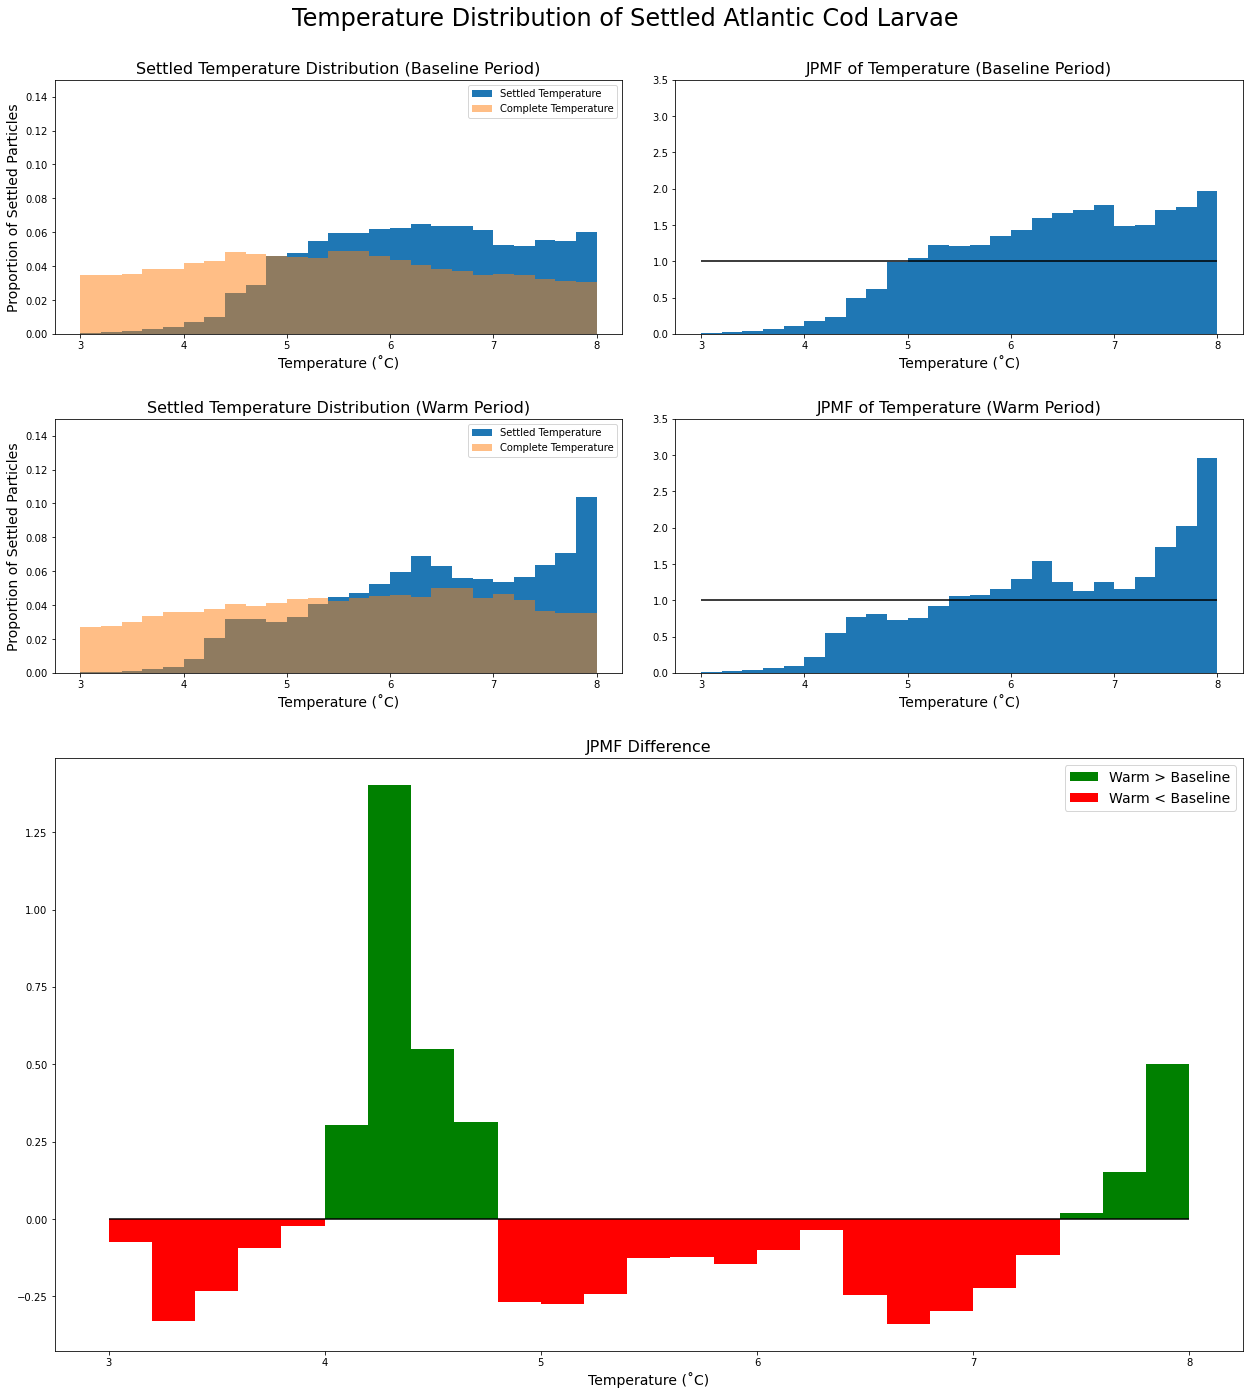

In [130]:
r = (3,8)

#fig, axes = plt.subplots(2, 2, figsize=(18, 12))
#ax1, ax2, ax3, ax4 = axes.ravel()

fig = plt.figure(figsize=(18, 20))

ax1 = plt.subplot2grid((4, 2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((4, 2), (0, 1), colspan=1)
ax3 = plt.subplot2grid((4, 2), (1, 0), colspan=1)
ax4 = plt.subplot2grid((4, 2), (1, 1), colspan=1)
ax5 = plt.subplot2grid((4, 2), (2, 0), colspan=2, rowspan=2)

width = (base_bins[1] - base_bins[0])
center = (base_bins[:-1] + base_bins[1:]) / 2
ax1.bar(center, h_settled_temp_base, align='center', width=width, label="Settled Temperature")
ax1.bar(center, h_all_temps_base, align="center", width=width, alpha=0.5, label="Complete Temperature")
ax1.set_title("Settled Temperature Distribution (Baseline Period)", fontsize=16)
ax1.set_ylabel("Proportion of Settled Particles", fontsize=14)
ax1.set_xlabel("Temperature (˚C)", fontsize=14)
ax1.set_ylim((0, 0.15))
ax1.legend()

ax2.bar(center, h_std_base, align='center', width=width)
ax2.hlines(1.00, r[0], r[1], color="k")
ax2.set_title("JPMF of Temperature (Baseline Period)", fontsize=16)
ax2.set_xlabel("Temperature (˚C)", fontsize=14)
ax2.set_ylim((0, 3.5))

width = (warm_bins[1] - warm_bins[0])
center = (warm_bins[:-1] + warm_bins[1:]) / 2
ax3.bar(center, h_settled_temp_warm, align='center', width=width, label="Settled Temperature")
ax3.bar(center, h_all_temps_warm, align="center", width=width, alpha=0.5, label="Complete Temperature")
ax3.set_title("Settled Temperature Distribution (Warm Period)", fontsize=16)
ax3.set_ylabel("Proportion of Settled Particles", fontsize=14)
ax3.set_xlabel("Temperature (˚C)", fontsize=14)
ax3.set_ylim((0, 0.15))
ax3.legend()

ax4.bar(center, h_std_warm, align='center', width=width)
ax4.hlines(1.00, r[0], r[1], color="k")
ax4.set_title("JPMF of Temperature (Warm Period)", fontsize=16)
ax4.set_xlabel("Temperature (˚C)", fontsize=14)
ax4.set_ylim((0, 3.5))

h_std = (h_std_warm-h_std_base)/h_std_base

mask = h_std < 0

ax5.bar(center[~mask], h_std[~mask], color="green", align='center', width=width, label="Warm > Baseline")
ax5.bar(center[mask], h_std[mask], color="red", align='center', width=width, label="Warm < Baseline")
ax5.hlines(0.00, r[0], r[1], color="k")
ax5.set_title("JPMF Difference", fontsize=16)
ax5.set_xlabel("Temperature (˚C)", fontsize=14)
ax5.legend(fontsize=14)

fig.suptitle("Temperature Distribution of Settled Atlantic Cod Larvae", fontsize=24)

fig.tight_layout(pad=3.0)

plt.savefig("../figs/settlement-probability/cod_temp_settled.png")

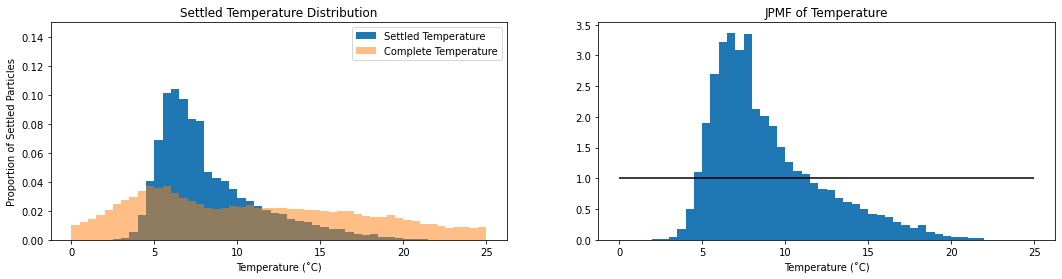

In [43]:
ax1, ax2, h_settled_temp, h_all_temps, h_std = plot_temp_histograms(baseline_unsett_temps, base_temps, 50, (0, 25))

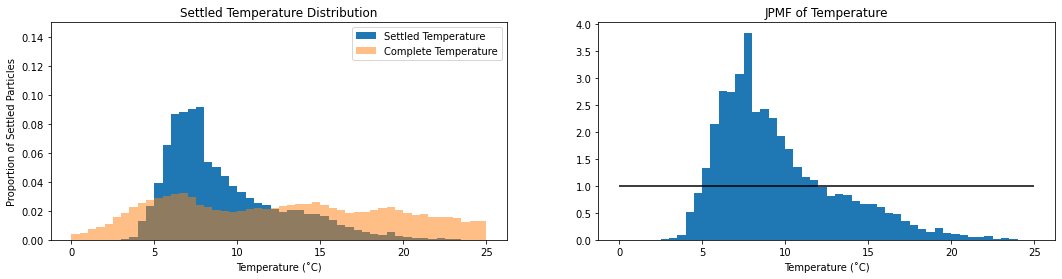

In [44]:
ax1, ax2, h_settled_temp, h_all_temps, h_std = plot_temp_histograms(warm_unsett_temps, warm_temps, 50, (0, 25))

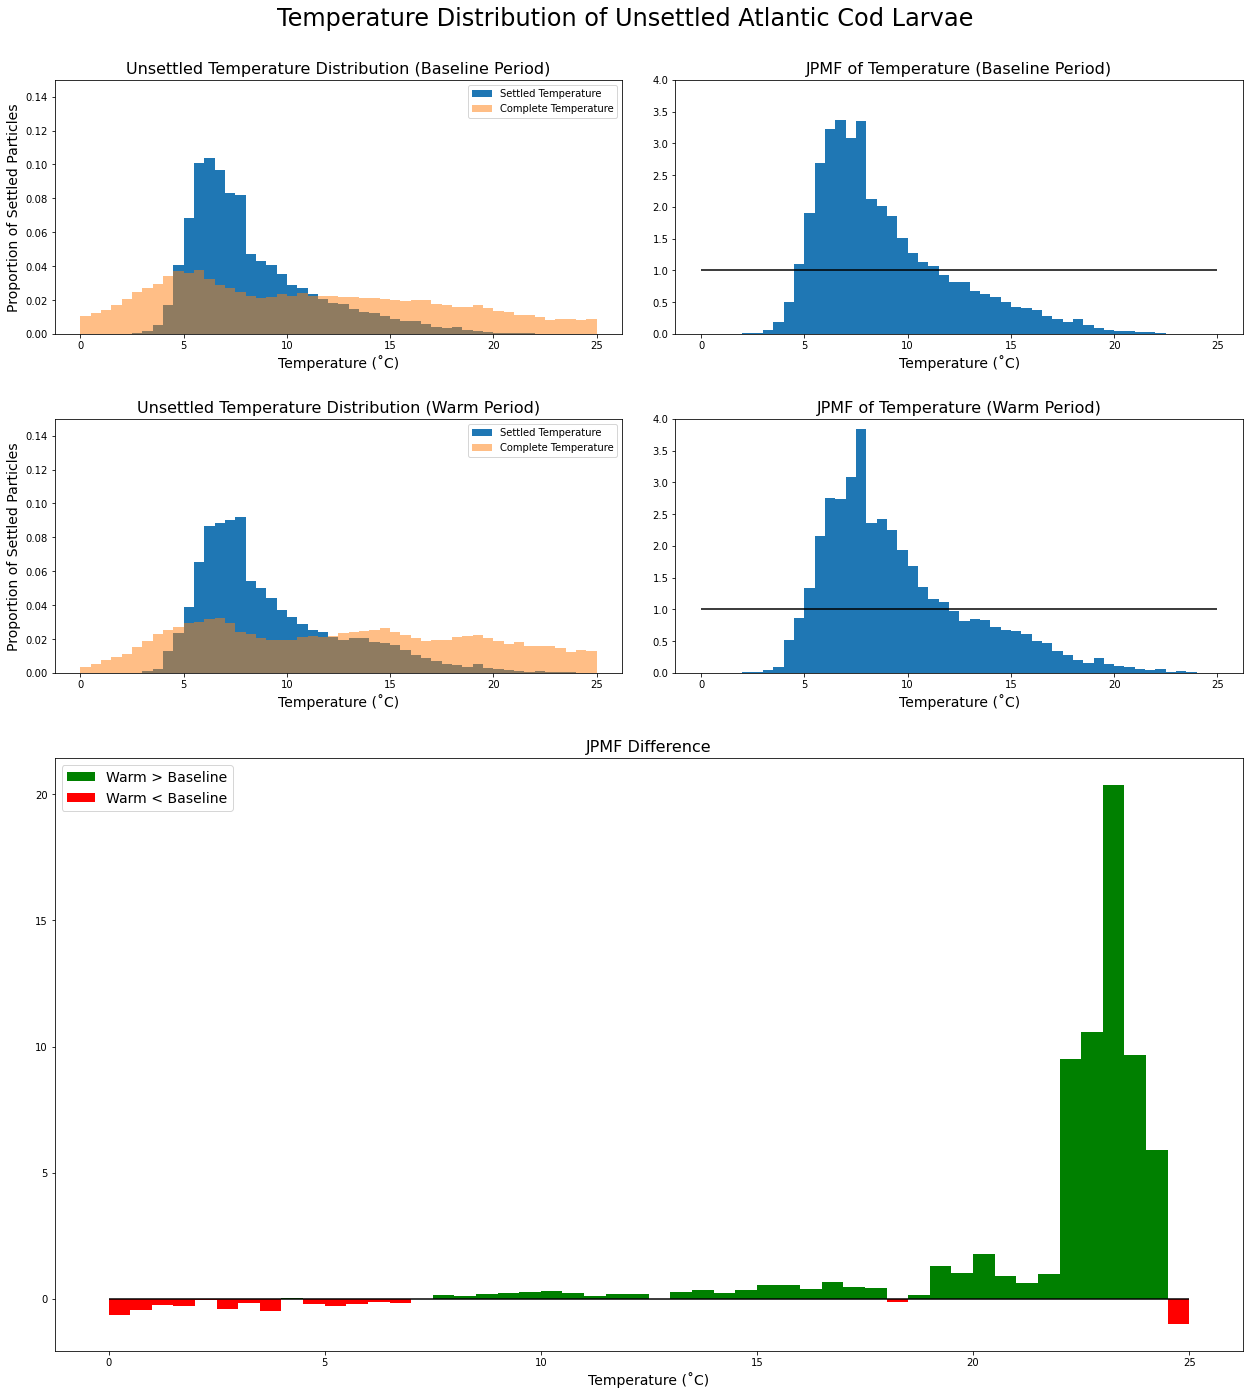

In [131]:
r = (0, 25)

h_unsett_temp_base, h_all_temps_base, h_std_base, base_bins = compute_temp_histograms(baseline_unsett_temps, base_temps, 50, r)
h_unsett_temp_warm, h_all_temps_warm, h_std_warm, warm_bins = compute_temp_histograms(warm_unsett_temps, warm_temps, 50, r)

fig = plt.figure(figsize=(18, 20))

ax1 = plt.subplot2grid((4, 2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((4, 2), (0, 1), colspan=1)
ax3 = plt.subplot2grid((4, 2), (1, 0), colspan=1)
ax4 = plt.subplot2grid((4, 2), (1, 1), colspan=1)
ax5 = plt.subplot2grid((4, 2), (2, 0), colspan=2, rowspan=2)

width = (base_bins[1] - base_bins[0])
center = (base_bins[:-1] + base_bins[1:]) / 2
ax1.bar(center, h_unsett_temp_base, align='center', width=width, label="Settled Temperature")
ax1.bar(center, h_all_temps_base, align="center", width=width, alpha=0.5, label="Complete Temperature")
ax1.set_title("Unsettled Temperature Distribution (Baseline Period)", fontsize=16)
ax1.set_ylabel("Proportion of Settled Particles", fontsize=14)
ax1.set_xlabel("Temperature (˚C)", fontsize=14)
ax1.set_ylim((0, 0.15))
ax1.legend()

ax2.bar(center, h_std_base, align='center', width=width)
ax2.hlines(1.00, r[0], r[1], color="k")
ax2.set_title("JPMF of Temperature (Baseline Period)", fontsize=16)
ax2.set_xlabel("Temperature (˚C)", fontsize=14)
ax2.set_ylim((0, 4.0))

width = (warm_bins[1] - warm_bins[0])
center = (warm_bins[:-1] + warm_bins[1:]) / 2
ax3.bar(center, h_unsett_temp_warm, align='center', width=width, label="Settled Temperature")
ax3.bar(center, h_all_temps_warm, align="center", width=width, alpha=0.5, label="Complete Temperature")
ax3.set_title("Unsettled Temperature Distribution (Warm Period)", fontsize=16)
ax3.set_ylabel("Proportion of Settled Particles", fontsize=14)
ax3.set_xlabel("Temperature (˚C)", fontsize=14)
ax3.set_ylim((0, 0.15))
ax3.legend()

ax4.bar(center, h_std_warm, align='center', width=width)
ax4.hlines(1.00, r[0], r[1], color="k")
ax4.set_title("JPMF of Temperature (Warm Period)", fontsize=16)
ax4.set_xlabel("Temperature (˚C)", fontsize=14)
ax4.set_ylim((0, 4.0))

h_std = (h_std_warm-h_std_base)/h_std_base

mask = h_std < 0

ax5.bar(center[~mask], h_std[~mask], color="green", align='center', width=width, label="Warm > Baseline")
ax5.bar(center[mask], h_std[mask], color="red", align='center', width=width, label="Warm < Baseline")
ax5.hlines(0.00, r[0], r[1], color="k")
ax5.set_title("JPMF Difference", fontsize=16)
ax5.set_xlabel("Temperature (˚C)", fontsize=14)
ax5.legend(fontsize=14)

fig.suptitle("Temperature Distribution of Unsettled Atlantic Cod Larvae", fontsize=24)

fig.tight_layout(pad=3.0)

plt.savefig("../figs/settlement-probability/cod_temp_unsettled.png")

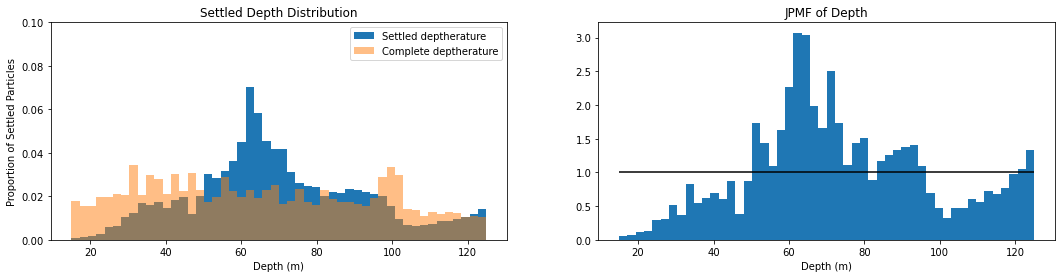

In [52]:
ax1, ax2, h_settled_temp, h_all_temps, h_std_base = plot_depth_histograms(baseline_sett_depths, base_depths, 50, (15, 125), save="cod_base_depth.png")

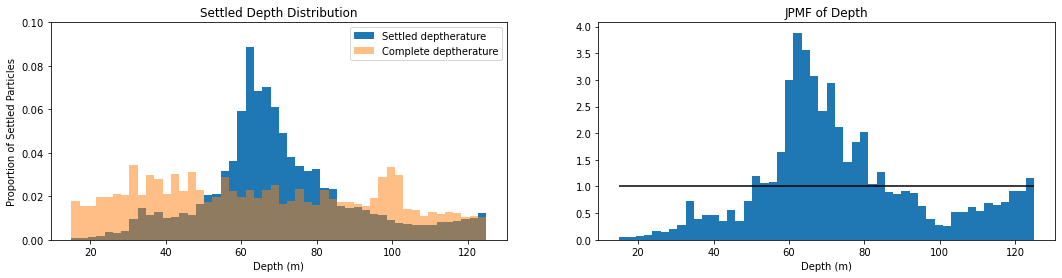

In [51]:
ax1, ax2, h_settled_temp, h_all_temps, h_std_warm = plot_depth_histograms(warm_sett_depths, warm_depths, 50, (15, 125), save="cod_warm_depth.png")

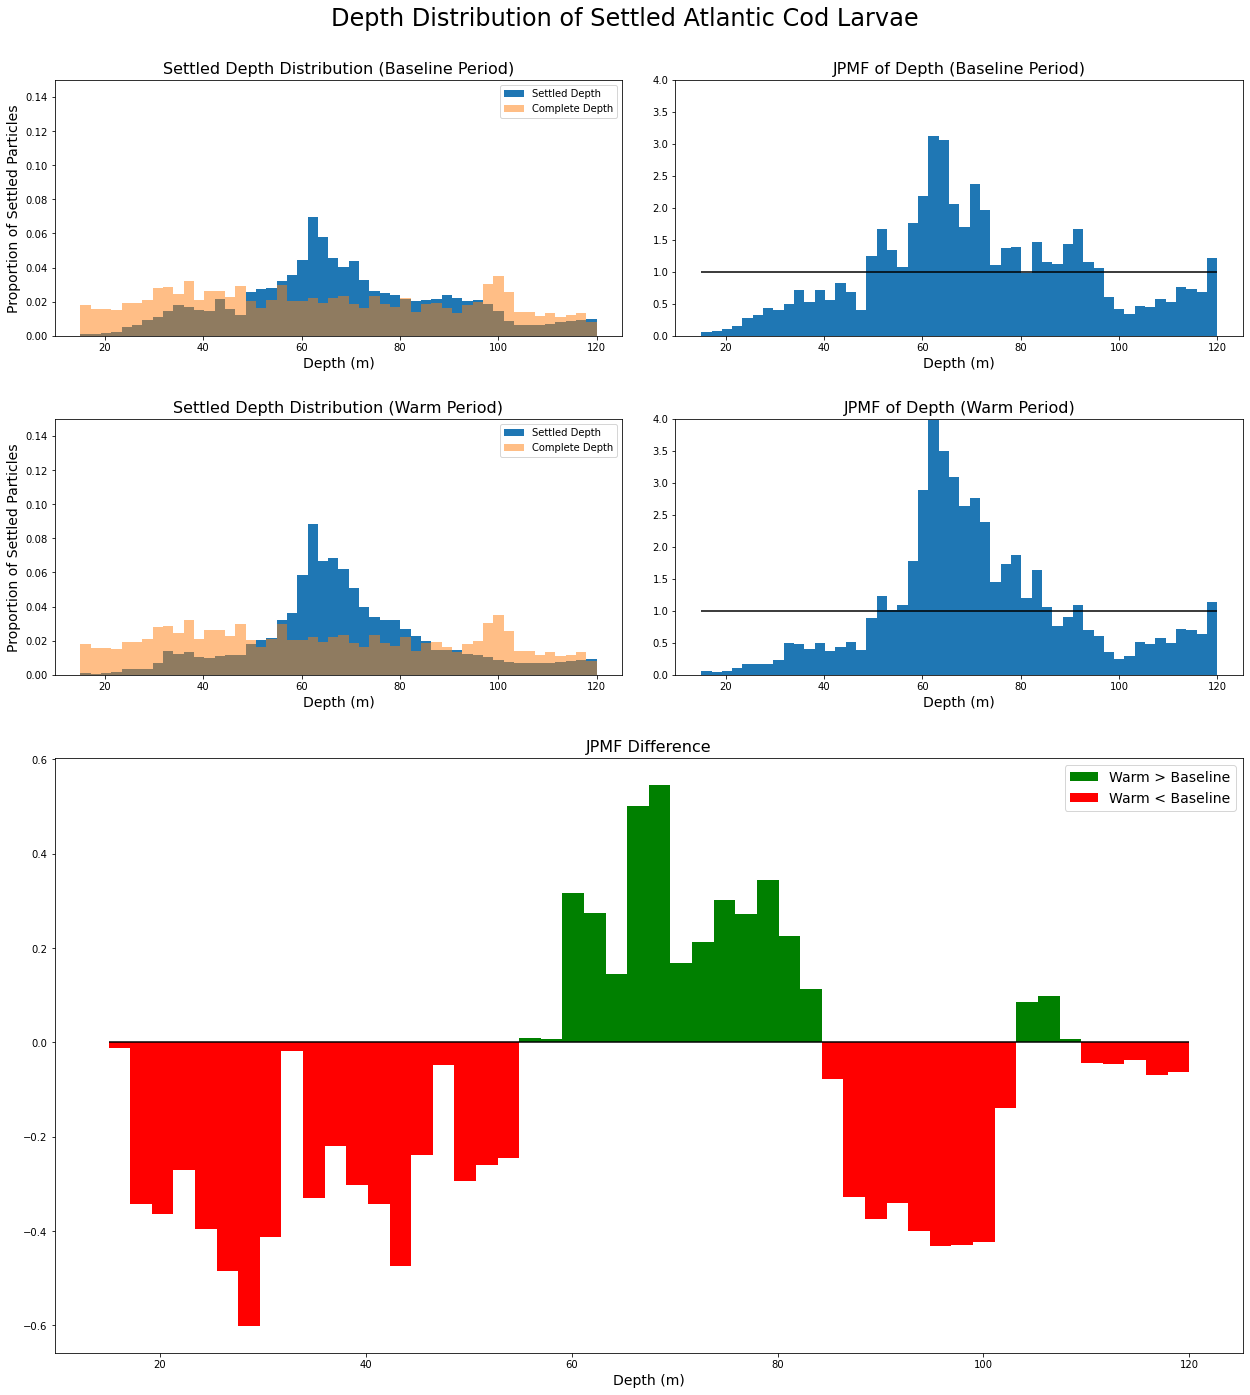

In [132]:
r = (15, 120)

h_settled_depth_base, h_all_depth_base, h_std_base, base_bins = compute_temp_histograms(baseline_sett_depths, base_depths, 50, r)
h_settled_depth_warm, h_all_depth_warm, h_std_warm, warm_bins = compute_temp_histograms(warm_sett_depths, warm_depths, 50, r)

fig = plt.figure(figsize=(18, 20))

ax1 = plt.subplot2grid((4, 2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((4, 2), (0, 1), colspan=1)
ax3 = plt.subplot2grid((4, 2), (1, 0), colspan=1)
ax4 = plt.subplot2grid((4, 2), (1, 1), colspan=1)
ax5 = plt.subplot2grid((4, 2), (2, 0), colspan=2, rowspan=2)

width = (base_bins[1] - base_bins[0])
center = (base_bins[:-1] + base_bins[1:]) / 2
ax1.bar(center, h_settled_depth_base, align='center', width=width, label="Settled Depth")
ax1.bar(center, h_all_depth_base, align="center", width=width, alpha=0.5, label="Complete Depth")
ax1.set_title("Settled Depth Distribution (Baseline Period)", fontsize=16)
ax1.set_ylabel("Proportion of Settled Particles", fontsize=14)
ax1.set_xlabel("Depth (m)", fontsize=14)
ax1.set_ylim((0, 0.15))
ax1.legend()

ax2.bar(center, h_std_base, align='center', width=width)
ax2.hlines(1.00, r[0], r[1], color="k")
ax2.set_title("JPMF of Depth (Baseline Period)", fontsize=16)
ax2.set_xlabel("Depth (m)", fontsize=14)
ax2.set_ylim((0, 4.0))

width = (warm_bins[1] - warm_bins[0])
center = (warm_bins[:-1] + warm_bins[1:]) / 2
ax3.bar(center, h_settled_depth_warm, align='center', width=width, label="Settled Depth")
ax3.bar(center, h_all_depth_warm, align="center", width=width, alpha=0.5, label="Complete Depth")
ax3.set_title("Settled Depth Distribution (Warm Period)", fontsize=16)
ax3.set_ylabel("Proportion of Settled Particles", fontsize=14)
ax3.set_xlabel("Depth (m)", fontsize=14)
ax3.set_ylim((0, 0.15))
ax3.legend()

ax4.bar(center, h_std_warm, align='center', width=width)
ax4.hlines(1.00, r[0], r[1], color="k")
ax4.set_title("JPMF of Depth (Warm Period)", fontsize=16)
ax4.set_xlabel("Depth (m)", fontsize=14)
ax4.set_ylim((0, 4.0))

h_std = (h_std_warm-h_std_base)/h_std_base

mask = h_std < 0

ax5.bar(center[~mask], h_std[~mask], color="green", align='center', width=width, label="Warm > Baseline")
ax5.bar(center[mask], h_std[mask], color="red", align='center', width=width, label="Warm < Baseline")
ax5.hlines(0.00, r[0], r[1], color="k")
ax5.set_title("JPMF Difference", fontsize=16)
ax5.set_xlabel("Depth (m)", fontsize=14)
ax5.legend(fontsize=14)

fig.suptitle("Depth Distribution of Settled Atlantic Cod Larvae", fontsize=24)

fig.tight_layout(pad=3.0)

plt.savefig("../figs/settlement-probability/cod_depth_settled.png")

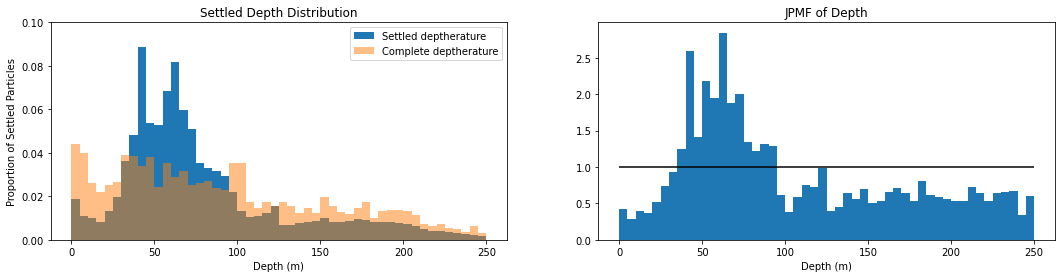

In [61]:
ax1, ax2, h_settled_temp, h_all_temps, h_std = plot_depth_histograms(baseline_unsett_depths, base_depths, 50, (0, 250))

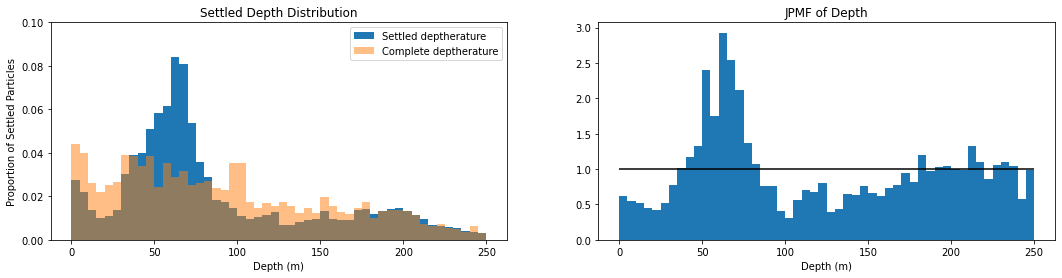

In [63]:
ax1, ax2, h_settled_temp, h_all_temps, h_std = plot_depth_histograms(warm_unsett_depths, warm_depths, 50, (0, 250))

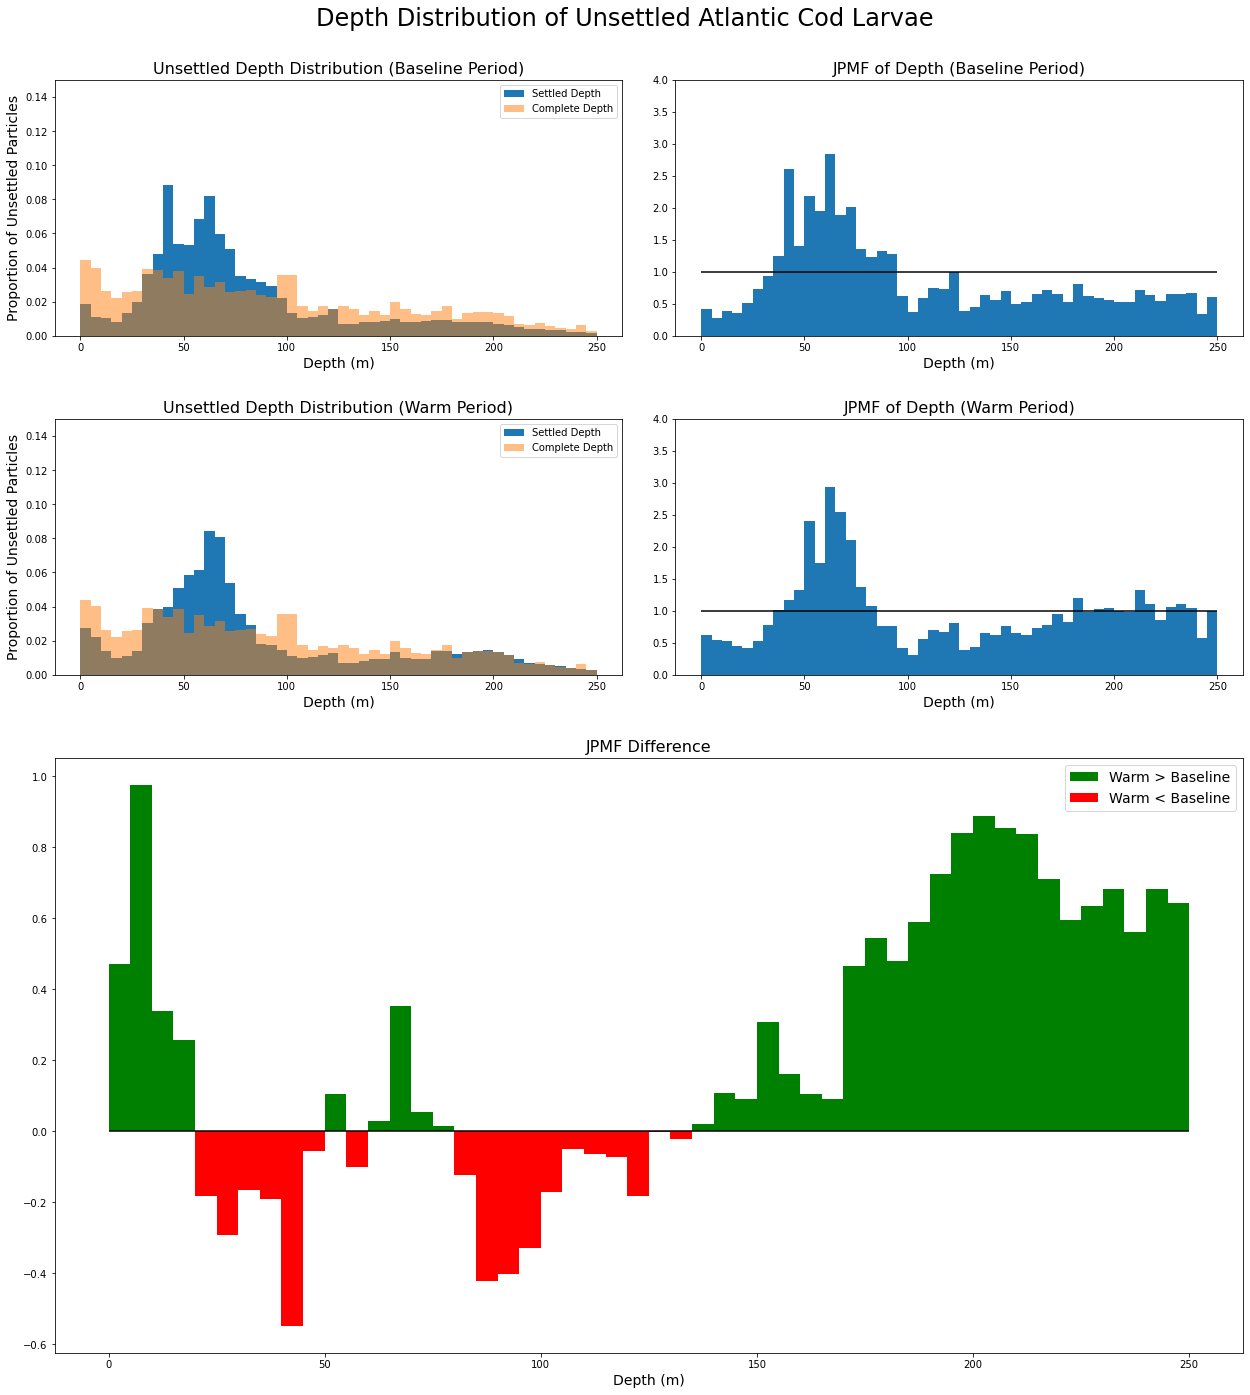

In [133]:
r = (0, 250)

h_unsett_depth_base, h_all_depth_base, h_std_base, base_bins = compute_temp_histograms(baseline_unsett_depths, base_depths, 50, r)
h_unsett_depth_warm, h_all_depth_warm, h_std_warm, warm_bins = compute_temp_histograms(warm_unsett_depths, warm_depths, 50, r)

fig = plt.figure(figsize=(18, 20))

ax1 = plt.subplot2grid((4, 2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((4, 2), (0, 1), colspan=1)
ax3 = plt.subplot2grid((4, 2), (1, 0), colspan=1)
ax4 = plt.subplot2grid((4, 2), (1, 1), colspan=1)
ax5 = plt.subplot2grid((4, 2), (2, 0), colspan=2, rowspan=2)

width = (base_bins[1] - base_bins[0])
center = (base_bins[:-1] + base_bins[1:]) / 2
ax1.bar(center, h_unsett_depth_base, align='center', width=width, label="Settled Depth")
ax1.bar(center, h_all_depth_base, align="center", width=width, alpha=0.5, label="Complete Depth")
ax1.set_title("Unsettled Depth Distribution (Baseline Period)", fontsize=16)
ax1.set_ylabel("Proportion of Unsettled Particles", fontsize=14)
ax1.set_xlabel("Depth (m)", fontsize=14)
ax1.set_ylim((0, 0.15))
ax1.legend()

ax2.bar(center, h_std_base, align='center', width=width)
ax2.hlines(1.00, r[0], r[1], color="k")
ax2.set_title("JPMF of Depth (Baseline Period)", fontsize=16)
ax2.set_xlabel("Depth (m)", fontsize=14)
ax2.set_ylim((0, 4.0))

width = (warm_bins[1] - warm_bins[0])
center = (warm_bins[:-1] + warm_bins[1:]) / 2
ax3.bar(center, h_unsett_depth_warm, align='center', width=width, label="Settled Depth")
ax3.bar(center, h_all_depth_warm, align="center", width=width, alpha=0.5, label="Complete Depth")
ax3.set_title("Unsettled Depth Distribution (Warm Period)", fontsize=16)
ax3.set_ylabel("Proportion of Unsettled Particles", fontsize=14)
ax3.set_xlabel("Depth (m)", fontsize=14)
ax3.set_ylim((0, 0.15))
ax3.legend()

ax4.bar(center, h_std_warm, align='center', width=width)
ax4.hlines(1.00, r[0], r[1], color="k")
ax4.set_title("JPMF of Depth (Warm Period)", fontsize=16)
ax4.set_xlabel("Depth (m)", fontsize=14)
ax4.set_ylim((0, 4.0))

h_std = (h_std_warm-h_std_base)/h_std_base

mask = h_std < 0

ax5.bar(center[~mask], h_std[~mask], color="green", align='center', width=width, label="Warm > Baseline")
ax5.bar(center[mask], h_std[mask], color="red", align='center', width=width, label="Warm < Baseline")
ax5.hlines(0.00, r[0], r[1], color="k")
ax5.set_title("JPMF Difference", fontsize=16)
ax5.set_xlabel("Depth (m)", fontsize=14)
ax5.legend(fontsize=14)

fig.suptitle("Depth Distribution of Unsettled Atlantic Cod Larvae", fontsize=24)

fig.tight_layout(pad=3.0)

plt.savefig("../figs/settlement-probability/cod_depth_unsettled.png")

# Atlantic Mackerel

In [134]:
months = range(6, 9)
fname = "fiscm_group_001.nc"

In [135]:
base_temps, base_depths = get_temp_for_all_years(range(1984, 1989), months)
warm_temps, warm_depths = get_temp_for_all_years(range(2012, 2017), months)
#cold_temps, cold_depths = get_temp_for_all_years(range(1993, 1998), months)

In [136]:
baseline_start, baseline_end, baseline_settled = data.get_data_for_years(
    '../../model_runs/data/atlantic-mackerel/baseline_data', 
    range(1984, 1989), 
    "settlement.nc"
)

baseline_settled     = baseline_settled.astype(int)
baseline_sett_temps  = baseline_end[baseline_settled, 3]
baseline_sett_depths = baseline_end[baseline_settled, 4]

baseline_unsett_temps  = baseline_end[~baseline_settled, 3]
baseline_unsett_depths = baseline_end[~baseline_settled, 4]

['../../model_runs/data/atlantic-mackerel/baseline_data/Year1984/05-may/settlement.nc', '../../model_runs/data/atlantic-mackerel/baseline_data/Year1984/06-jun/settlement.nc']
['../../model_runs/data/atlantic-mackerel/baseline_data/Year1985/05-may/settlement.nc', '../../model_runs/data/atlantic-mackerel/baseline_data/Year1985/06-jun/settlement.nc']
['../../model_runs/data/atlantic-mackerel/baseline_data/Year1986/05-may/settlement.nc', '../../model_runs/data/atlantic-mackerel/baseline_data/Year1986/06-jun/settlement.nc']
['../../model_runs/data/atlantic-mackerel/baseline_data/Year1987/05-may/settlement.nc', '../../model_runs/data/atlantic-mackerel/baseline_data/Year1987/06-jun/settlement.nc']
['../../model_runs/data/atlantic-mackerel/baseline_data/Year1988/05-may/settlement.nc', '../../model_runs/data/atlantic-mackerel/baseline_data/Year1988/06-jun/settlement.nc']


In [106]:
np.max(baseline_sett_temps)

9.999999564187211

In [137]:
warm_start, warm_end, warm_settled = data.get_data_for_years(
    '../../model_runs/data/atlantic-mackerel/warm_period', 
    range(2012, 2017), 
    "settlement.nc"
)

warm_settled     = warm_settled.astype(int)
warm_sett_temps  = warm_end[warm_settled, 3]
warm_sett_depths = warm_end[warm_settled, 4]

warm_unsett_temps  = warm_end[~warm_settled, 3]
warm_unsett_depths = warm_end[~warm_settled, 4]

['../../model_runs/data/atlantic-mackerel/warm_period/Year2012/05-may/settlement.nc', '../../model_runs/data/atlantic-mackerel/warm_period/Year2012/06-jun/settlement.nc']
['../../model_runs/data/atlantic-mackerel/warm_period/Year2013/05-may/settlement.nc', '../../model_runs/data/atlantic-mackerel/warm_period/Year2013/06-jun/settlement.nc']
['../../model_runs/data/atlantic-mackerel/warm_period/Year2014/05-may/settlement.nc', '../../model_runs/data/atlantic-mackerel/warm_period/Year2014/06-jun/settlement.nc']
['../../model_runs/data/atlantic-mackerel/warm_period/Year2015/05-may/settlement.nc', '../../model_runs/data/atlantic-mackerel/warm_period/Year2015/06-jun/settlement.nc']
['../../model_runs/data/atlantic-mackerel/warm_period/Year2016/05-may/settlement.nc', '../../model_runs/data/atlantic-mackerel/warm_period/Year2016/06-jun/settlement.nc']


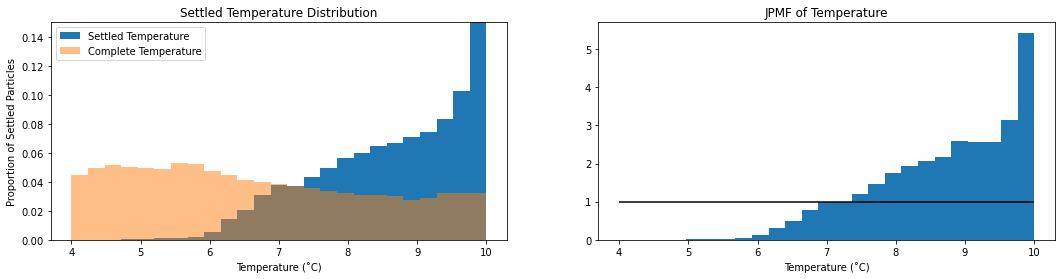

In [107]:
ax1, ax2, h_settled_temp, h_all_temps, h_std_base = plot_temp_histograms(baseline_sett_temps, base_temps, 25, (4, 10), save="cod_base_temp.png")

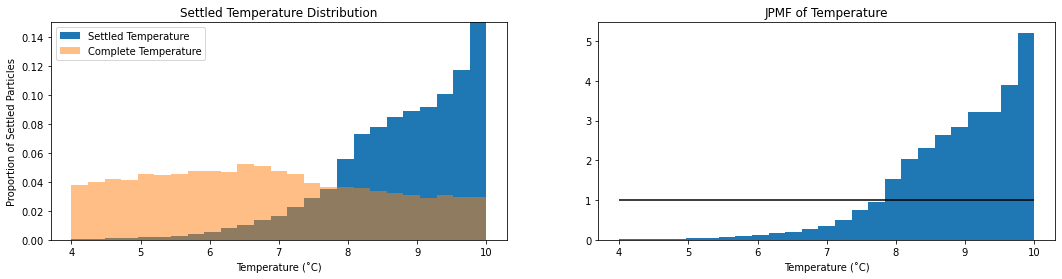

In [108]:
ax1, ax2, h_settled_temp, h_all_temps, h_std_warm = plot_temp_histograms(warm_sett_temps, warm_temps, 25, (4, 10), save="cod_warm_temp.png")

In [139]:
h_settled_temp_base, h_all_temps_base, h_std_base, base_bins = compute_temp_histograms(baseline_sett_temps, base_temps, 25, (4, 10))
h_settled_temp_warm, h_all_temps_warm, h_std_warm, warm_bins = compute_temp_histograms(warm_sett_temps, warm_temps, 25, (4, 10))

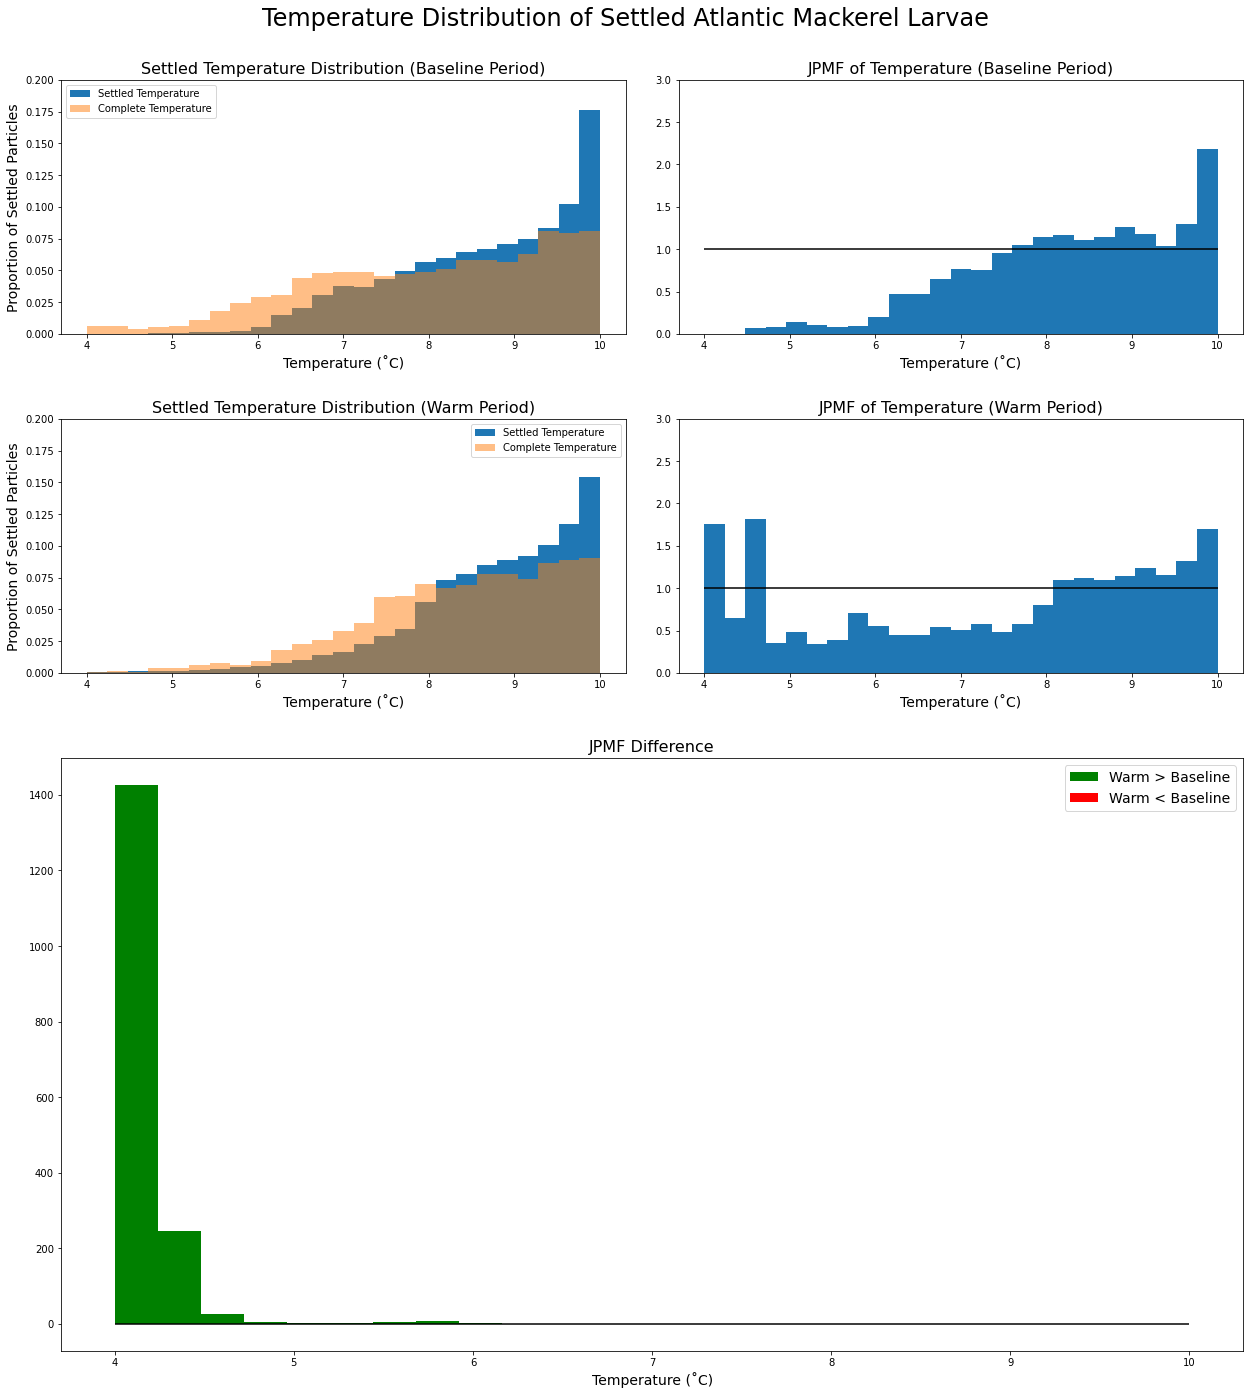

In [141]:
r = (4, 10)

#fig, axes = plt.subplots(2, 2, figsize=(18, 12))
#ax1, ax2, ax3, ax4 = axes.ravel()

fig = plt.figure(figsize=(18, 20))

ax1 = plt.subplot2grid((4, 2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((4, 2), (0, 1), colspan=1)
ax3 = plt.subplot2grid((4, 2), (1, 0), colspan=1)
ax4 = plt.subplot2grid((4, 2), (1, 1), colspan=1)
ax5 = plt.subplot2grid((4, 2), (2, 0), colspan=2, rowspan=2)

width = (base_bins[1] - base_bins[0])
center = (base_bins[:-1] + base_bins[1:]) / 2
ax1.bar(center, h_settled_temp_base, align='center', width=width, label="Settled Temperature")
ax1.bar(center, h_all_temps_base, align="center", width=width, alpha=0.5, label="Complete Temperature")
ax1.set_title("Settled Temperature Distribution (Baseline Period)", fontsize=16)
ax1.set_ylabel("Proportion of Settled Particles", fontsize=14)
ax1.set_xlabel("Temperature (˚C)", fontsize=14)
ax1.set_ylim((0, 0.2))
ax1.legend()

ax2.bar(center, h_std_base, align='center', width=width)
ax2.hlines(1.00, r[0], r[1], color="k")
ax2.set_title("JPMF of Temperature (Baseline Period)", fontsize=16)
ax2.set_xlabel("Temperature (˚C)", fontsize=14)
ax2.set_ylim((0, 3))

width = (warm_bins[1] - warm_bins[0])
center = (warm_bins[:-1] + warm_bins[1:]) / 2
ax3.bar(center, h_settled_temp_warm, align='center', width=width, label="Settled Temperature")
ax3.bar(center, h_all_temps_warm, align="center", width=width, alpha=0.5, label="Complete Temperature")
ax3.set_title("Settled Temperature Distribution (Warm Period)", fontsize=16)
ax3.set_ylabel("Proportion of Settled Particles", fontsize=14)
ax3.set_xlabel("Temperature (˚C)", fontsize=14)
ax3.set_ylim((0, 0.2))
ax3.legend()

ax4.bar(center, h_std_warm, align='center', width=width)
ax4.hlines(1.00, r[0], r[1], color="k")
ax4.set_title("JPMF of Temperature (Warm Period)", fontsize=16)
ax4.set_xlabel("Temperature (˚C)", fontsize=14)
ax4.set_ylim((0, 3))

h_std = (h_std_warm-h_std_base)/h_std_base

mask = h_std < 0

ax5.bar(center[~mask], h_std[~mask], color="green", align='center', width=width, label="Warm > Baseline")
ax5.bar(center[mask], h_std[mask], color="red", align='center', width=width, label="Warm < Baseline")
ax5.hlines(0.00, r[0], r[1], color="k")
ax5.set_title("JPMF Difference", fontsize=16)
ax5.set_xlabel("Temperature (˚C)", fontsize=14)
ax5.legend(fontsize=14)

fig.suptitle("Temperature Distribution of Settled Atlantic Mackerel Larvae", fontsize=24)

fig.tight_layout(pad=3.0)

plt.savefig("../figs/settlement-probability/mac_temp_settled.png")

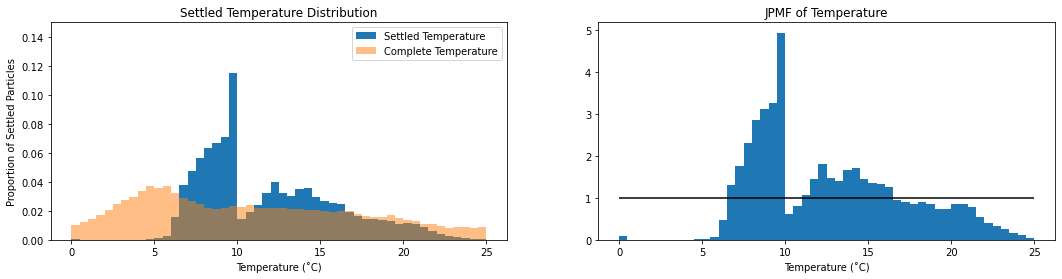

In [116]:
ax1, ax2, h_settled_temp, h_all_temps, h_std = plot_temp_histograms(baseline_unsett_temps, base_temps, 50, (0, 25))

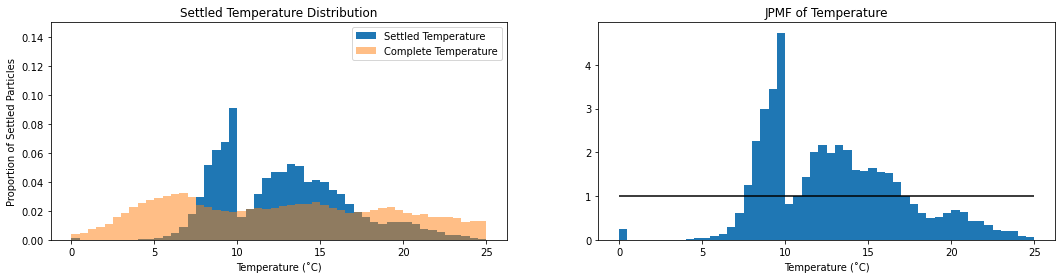

In [117]:
ax1, ax2, h_settled_temp, h_all_temps, h_std = plot_temp_histograms(warm_unsett_temps, warm_temps, 50, (0, 25))

/vortexfs1/home/jzahner/.conda/envs/larval-dispersal-modeling/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


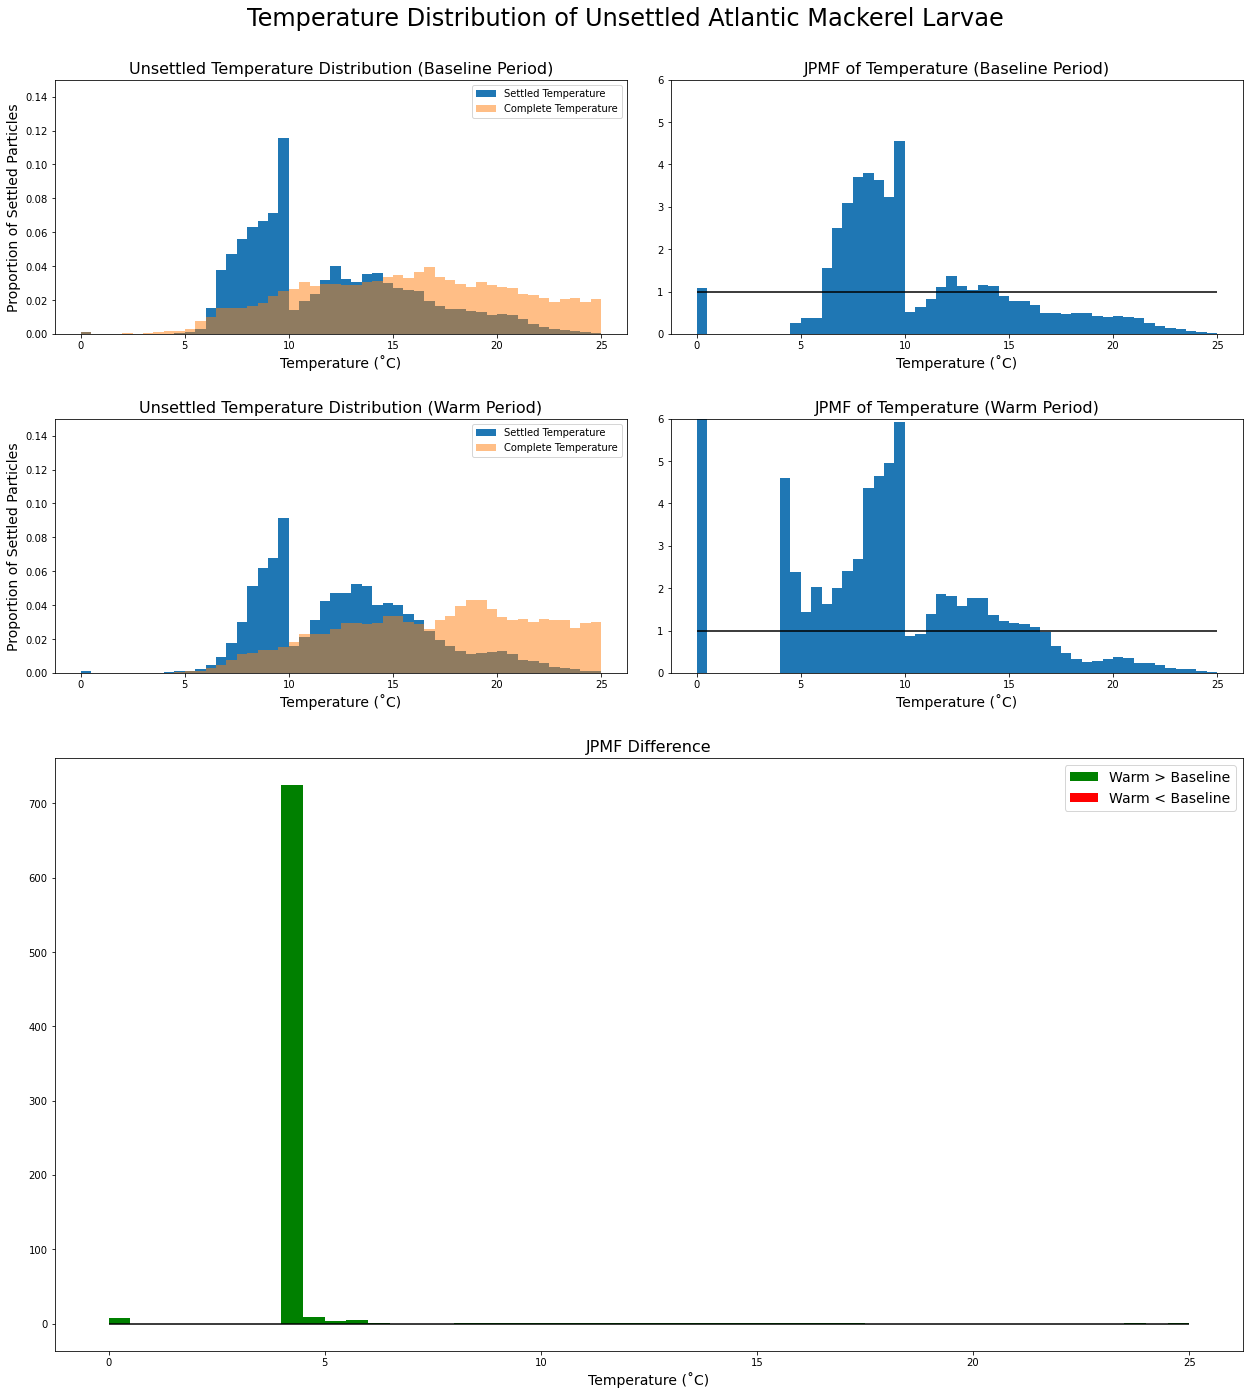

In [142]:
r = (0, 25)

h_unsett_temp_base, h_all_temps_base, h_std_base, base_bins = compute_temp_histograms(baseline_unsett_temps, base_temps, 50, r)
h_unsett_temp_warm, h_all_temps_warm, h_std_warm, warm_bins = compute_temp_histograms(warm_unsett_temps, warm_temps, 50, r)

fig = plt.figure(figsize=(18, 20))

ax1 = plt.subplot2grid((4, 2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((4, 2), (0, 1), colspan=1)
ax3 = plt.subplot2grid((4, 2), (1, 0), colspan=1)
ax4 = plt.subplot2grid((4, 2), (1, 1), colspan=1)
ax5 = plt.subplot2grid((4, 2), (2, 0), colspan=2, rowspan=2)

width = (base_bins[1] - base_bins[0])
center = (base_bins[:-1] + base_bins[1:]) / 2
ax1.bar(center, h_unsett_temp_base, align='center', width=width, label="Settled Temperature")
ax1.bar(center, h_all_temps_base, align="center", width=width, alpha=0.5, label="Complete Temperature")
ax1.set_title("Unsettled Temperature Distribution (Baseline Period)", fontsize=16)
ax1.set_ylabel("Proportion of Settled Particles", fontsize=14)
ax1.set_xlabel("Temperature (˚C)", fontsize=14)
ax1.set_ylim((0, 0.15))
ax1.legend()

ax2.bar(center, h_std_base, align='center', width=width)
ax2.hlines(1.00, r[0], r[1], color="k")
ax2.set_title("JPMF of Temperature (Baseline Period)", fontsize=16)
ax2.set_xlabel("Temperature (˚C)", fontsize=14)
ax2.set_ylim((0, 6.0))

width = (warm_bins[1] - warm_bins[0])
center = (warm_bins[:-1] + warm_bins[1:]) / 2
ax3.bar(center, h_unsett_temp_warm, align='center', width=width, label="Settled Temperature")
ax3.bar(center, h_all_temps_warm, align="center", width=width, alpha=0.5, label="Complete Temperature")
ax3.set_title("Unsettled Temperature Distribution (Warm Period)", fontsize=16)
ax3.set_ylabel("Proportion of Settled Particles", fontsize=14)
ax3.set_xlabel("Temperature (˚C)", fontsize=14)
ax3.set_ylim((0, 0.15))
ax3.legend()

ax4.bar(center, h_std_warm, align='center', width=width)
ax4.hlines(1.00, r[0], r[1], color="k")
ax4.set_title("JPMF of Temperature (Warm Period)", fontsize=16)
ax4.set_xlabel("Temperature (˚C)", fontsize=14)
ax4.set_ylim((0, 6.0))

h_std = (h_std_warm-h_std_base)/h_std_base

mask = h_std < 0

ax5.bar(center[~mask], h_std[~mask], color="green", align='center', width=width, label="Warm > Baseline")
ax5.bar(center[mask], h_std[mask], color="red", align='center', width=width, label="Warm < Baseline")
ax5.hlines(0.00, r[0], r[1], color="k")
ax5.set_title("JPMF Difference", fontsize=16)
ax5.set_xlabel("Temperature (˚C)", fontsize=14)
ax5.legend(fontsize=14)

fig.suptitle("Temperature Distribution of Unsettled Atlantic Mackerel Larvae", fontsize=24)

fig.tight_layout(pad=3.0)

plt.savefig("../figs/settlement-probability/mac_temp_unsettled.png")

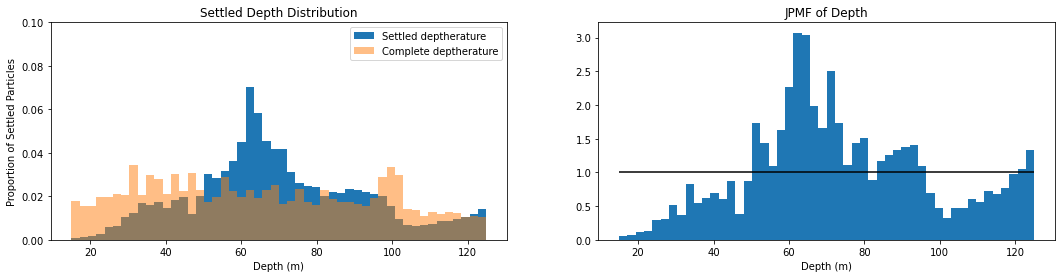

In [52]:
ax1, ax2, h_settled_temp, h_all_temps, h_std_base = plot_depth_histograms(baseline_sett_depths, base_depths, 50, (15, 125), save="cod_base_depth.png")

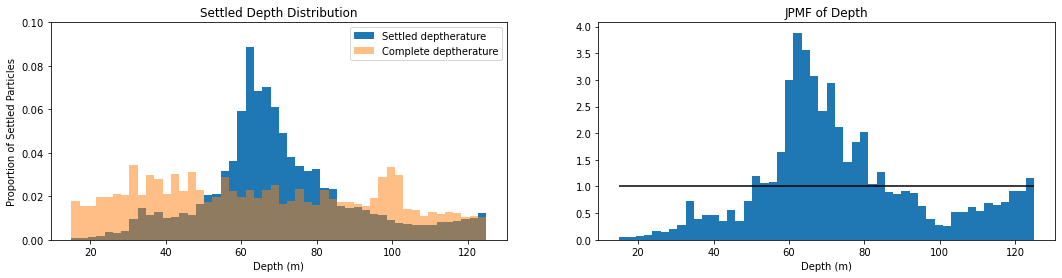

In [51]:
ax1, ax2, h_settled_temp, h_all_temps, h_std_warm = plot_depth_histograms(warm_sett_depths, warm_depths, 50, (15, 125), save="cod_warm_depth.png")

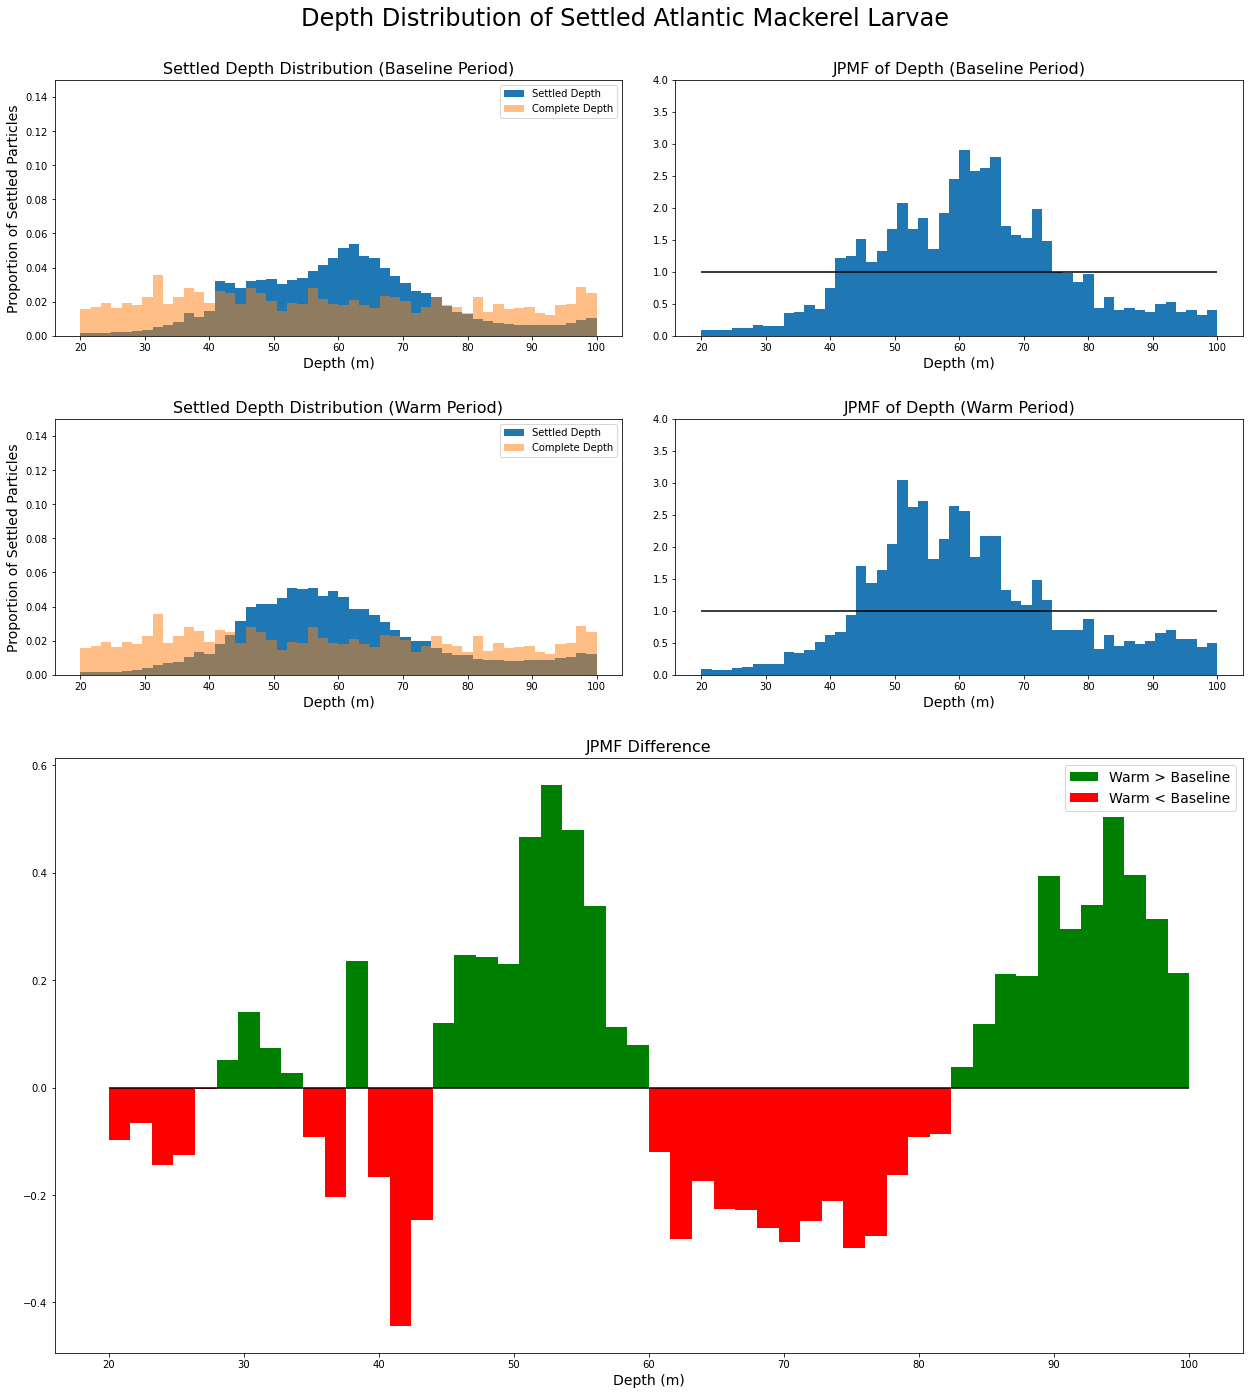

In [143]:
r = (20, 100)

h_settled_depth_base, h_all_depth_base, h_std_base, base_bins = compute_temp_histograms(baseline_sett_depths, base_depths, 50, r)
h_settled_depth_warm, h_all_depth_warm, h_std_warm, warm_bins = compute_temp_histograms(warm_sett_depths, warm_depths, 50, r)

fig = plt.figure(figsize=(18, 20))

ax1 = plt.subplot2grid((4, 2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((4, 2), (0, 1), colspan=1)
ax3 = plt.subplot2grid((4, 2), (1, 0), colspan=1)
ax4 = plt.subplot2grid((4, 2), (1, 1), colspan=1)
ax5 = plt.subplot2grid((4, 2), (2, 0), colspan=2, rowspan=2)

width = (base_bins[1] - base_bins[0])
center = (base_bins[:-1] + base_bins[1:]) / 2
ax1.bar(center, h_settled_depth_base, align='center', width=width, label="Settled Depth")
ax1.bar(center, h_all_depth_base, align="center", width=width, alpha=0.5, label="Complete Depth")
ax1.set_title("Settled Depth Distribution (Baseline Period)", fontsize=16)
ax1.set_ylabel("Proportion of Settled Particles", fontsize=14)
ax1.set_xlabel("Depth (m)", fontsize=14)
ax1.set_ylim((0, 0.15))
ax1.legend()

ax2.bar(center, h_std_base, align='center', width=width)
ax2.hlines(1.00, r[0], r[1], color="k")
ax2.set_title("JPMF of Depth (Baseline Period)", fontsize=16)
ax2.set_xlabel("Depth (m)", fontsize=14)
ax2.set_ylim((0, 4.0))

width = (warm_bins[1] - warm_bins[0])
center = (warm_bins[:-1] + warm_bins[1:]) / 2
ax3.bar(center, h_settled_depth_warm, align='center', width=width, label="Settled Depth")
ax3.bar(center, h_all_depth_warm, align="center", width=width, alpha=0.5, label="Complete Depth")
ax3.set_title("Settled Depth Distribution (Warm Period)", fontsize=16)
ax3.set_ylabel("Proportion of Settled Particles", fontsize=14)
ax3.set_xlabel("Depth (m)", fontsize=14)
ax3.set_ylim((0, 0.15))
ax3.legend()

ax4.bar(center, h_std_warm, align='center', width=width)
ax4.hlines(1.00, r[0], r[1], color="k")
ax4.set_title("JPMF of Depth (Warm Period)", fontsize=16)
ax4.set_xlabel("Depth (m)", fontsize=14)
ax4.set_ylim((0, 4.0))

h_std = (h_std_warm-h_std_base)/h_std_base

mask = h_std < 0

ax5.bar(center[~mask], h_std[~mask], color="green", align='center', width=width, label="Warm > Baseline")
ax5.bar(center[mask], h_std[mask], color="red", align='center', width=width, label="Warm < Baseline")
ax5.hlines(0.00, r[0], r[1], color="k")
ax5.set_title("JPMF Difference", fontsize=16)
ax5.set_xlabel("Depth (m)", fontsize=14)
ax5.legend(fontsize=14)

fig.suptitle("Depth Distribution of Settled Atlantic Mackerel Larvae", fontsize=24)

fig.tight_layout(pad=3.0)

plt.savefig("../figs/settlement-probability/mac_depth_settled.png")

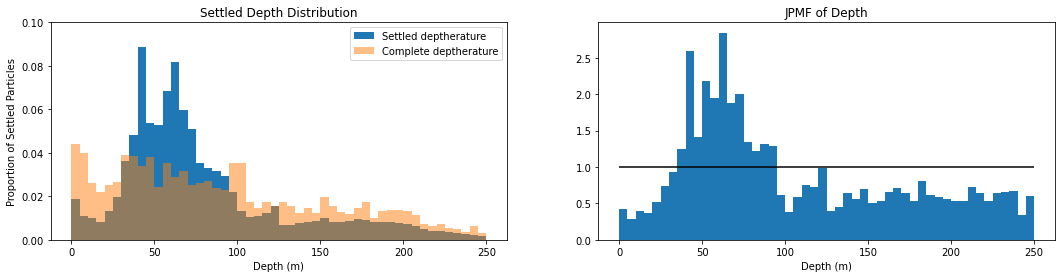

In [61]:
ax1, ax2, h_settled_temp, h_all_temps, h_std = plot_depth_histograms(baseline_unsett_depths, base_depths, 50, (0, 250))

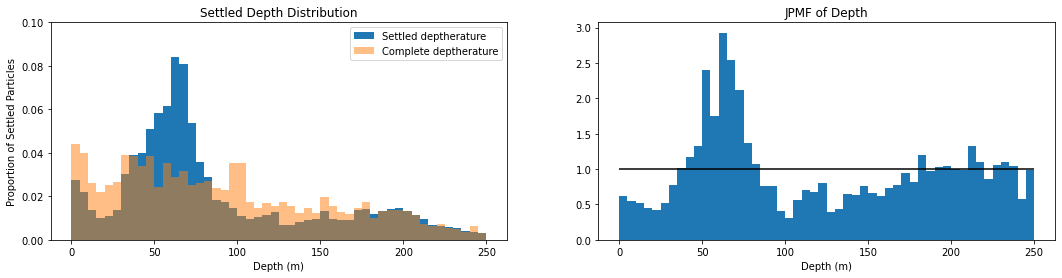

In [63]:
ax1, ax2, h_settled_temp, h_all_temps, h_std = plot_depth_histograms(warm_unsett_depths, warm_depths, 50, (0, 250))

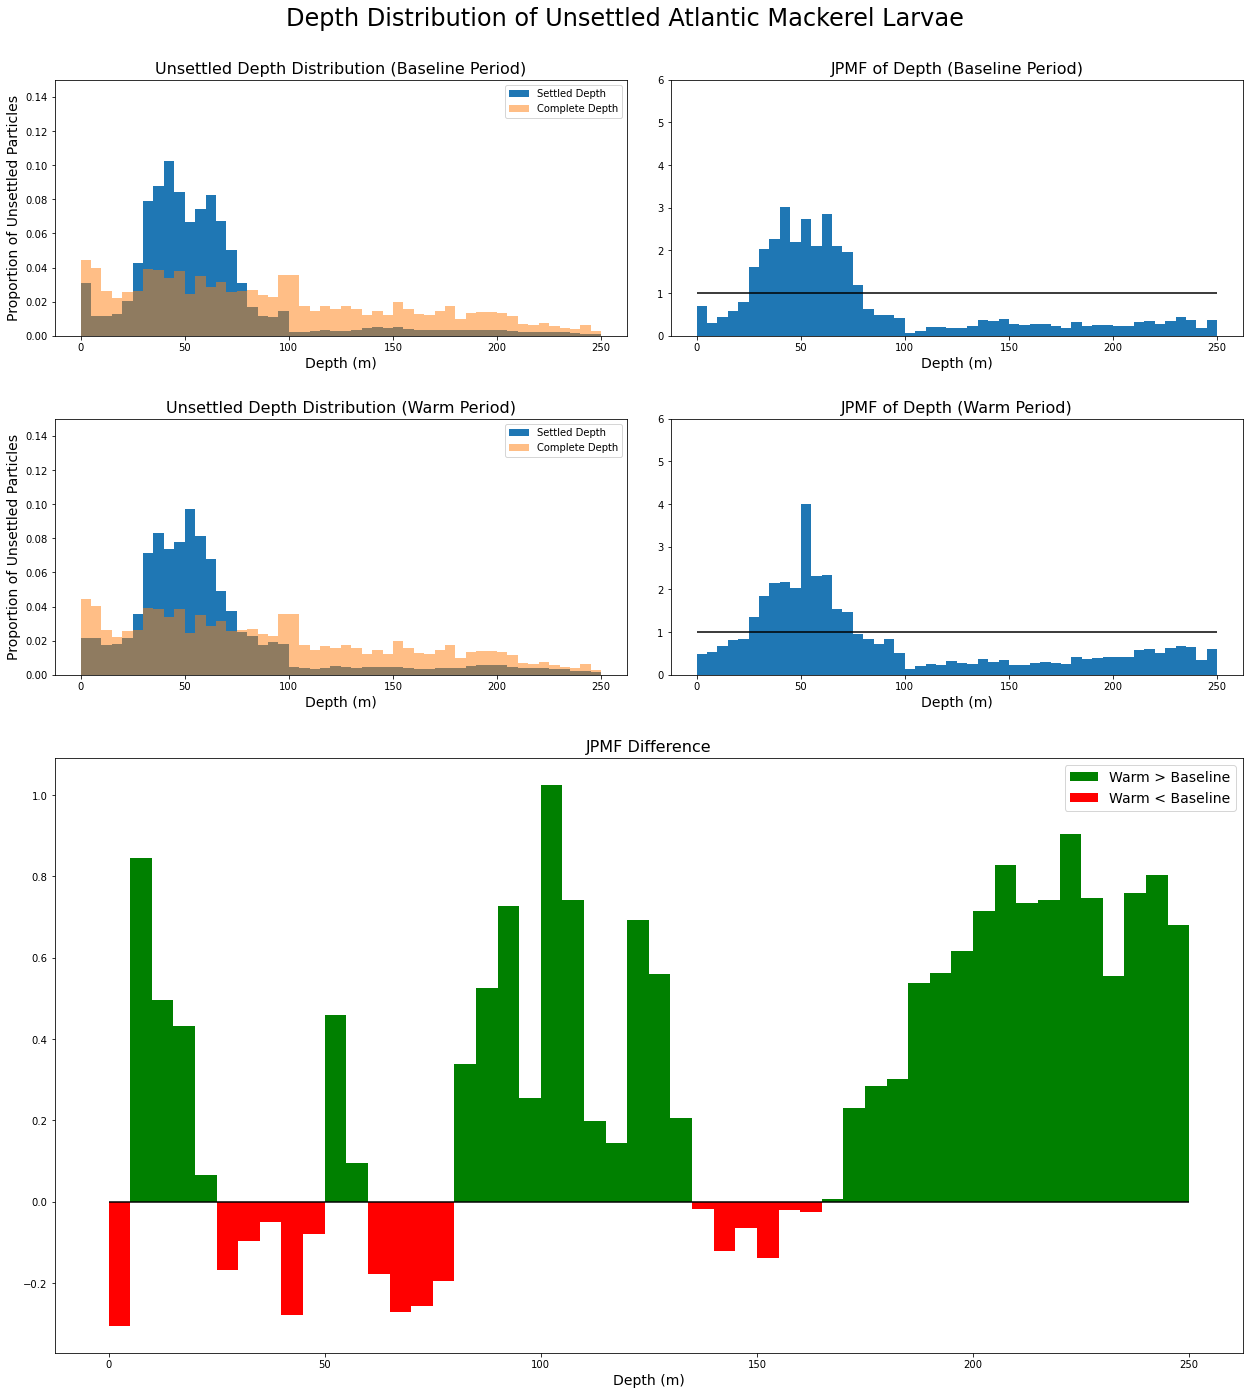

In [144]:
r = (0, 250)

h_unsett_depth_base, h_all_depth_base, h_std_base, base_bins = compute_temp_histograms(baseline_unsett_depths, base_depths, 50, r)
h_unsett_depth_warm, h_all_depth_warm, h_std_warm, warm_bins = compute_temp_histograms(warm_unsett_depths, warm_depths, 50, r)

fig = plt.figure(figsize=(18, 20))

ax1 = plt.subplot2grid((4, 2), (0, 0), colspan=1)
ax2 = plt.subplot2grid((4, 2), (0, 1), colspan=1)
ax3 = plt.subplot2grid((4, 2), (1, 0), colspan=1)
ax4 = plt.subplot2grid((4, 2), (1, 1), colspan=1)
ax5 = plt.subplot2grid((4, 2), (2, 0), colspan=2, rowspan=2)

width = (base_bins[1] - base_bins[0])
center = (base_bins[:-1] + base_bins[1:]) / 2
ax1.bar(center, h_unsett_depth_base, align='center', width=width, label="Settled Depth")
ax1.bar(center, h_all_depth_base, align="center", width=width, alpha=0.5, label="Complete Depth")
ax1.set_title("Unsettled Depth Distribution (Baseline Period)", fontsize=16)
ax1.set_ylabel("Proportion of Unsettled Particles", fontsize=14)
ax1.set_xlabel("Depth (m)", fontsize=14)
ax1.set_ylim((0, 0.15))
ax1.legend()

ax2.bar(center, h_std_base, align='center', width=width)
ax2.hlines(1.00, r[0], r[1], color="k")
ax2.set_title("JPMF of Depth (Baseline Period)", fontsize=16)
ax2.set_xlabel("Depth (m)", fontsize=14)
ax2.set_ylim((0, 6.0))

width = (warm_bins[1] - warm_bins[0])
center = (warm_bins[:-1] + warm_bins[1:]) / 2
ax3.bar(center, h_unsett_depth_warm, align='center', width=width, label="Settled Depth")
ax3.bar(center, h_all_depth_warm, align="center", width=width, alpha=0.5, label="Complete Depth")
ax3.set_title("Unsettled Depth Distribution (Warm Period)", fontsize=16)
ax3.set_ylabel("Proportion of Unsettled Particles", fontsize=14)
ax3.set_xlabel("Depth (m)", fontsize=14)
ax3.set_ylim((0, 0.15))
ax3.legend()

ax4.bar(center, h_std_warm, align='center', width=width)
ax4.hlines(1.00, r[0], r[1], color="k")
ax4.set_title("JPMF of Depth (Warm Period)", fontsize=16)
ax4.set_xlabel("Depth (m)", fontsize=14)
ax4.set_ylim((0, 6.0))

h_std = (h_std_warm-h_std_base)/h_std_base

mask = h_std < 0

ax5.bar(center[~mask], h_std[~mask], color="green", align='center', width=width, label="Warm > Baseline")
ax5.bar(center[mask], h_std[mask], color="red", align='center', width=width, label="Warm < Baseline")
ax5.hlines(0.00, r[0], r[1], color="k")
ax5.set_title("JPMF Difference", fontsize=16)
ax5.set_xlabel("Depth (m)", fontsize=14)
ax5.legend(fontsize=14)

fig.suptitle("Depth Distribution of Unsettled Atlantic Mackerel Larvae", fontsize=24)

fig.tight_layout(pad=3.0)

plt.savefig("../figs/settlement-probability/mac_depth_unsettled.png")